# Prediction with Machine Learning for Economists 
## Central European University, 2021/22 Fall

Instructor: Prof Gábor Békés, TA: János Bíró

Student: Mingming Li

Email: <Li_Mingming@phd.ceu.edu>

## Tasks for Assignment 2
### I discuss my idea and steps before the codes

Help company set to price their new apartments (small and mid-size apartments hosting 2-6 guests) not on the market in Berlin

In [9]:
import re
import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import percent_format
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from py_helper_functions import *
import warnings

warnings.filterwarnings("ignore")

## Data Prepare

In [10]:
data = pd.read_csv('listings.csv')

**We need a small and middle apartment, 2-6persons according to assignment**

In [11]:

data=data.loc[(data.accommodates < 7) & (data.accommodates > 1)]

**We need deal with missing values:**     
       For those not miss too many: use mean to replace it   
       For those miss not too many: drop the colloums 

In [12]:
# show the columns of missing value
na_filter=data.isna().sum()
na_filter[na_filter > 0].index

Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calendar_updated',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'reviews_per_month'],
      dtype='object')

In [13]:
# process the missing value
# fill median strategy with these attributes:
data['host_listings_count']=data['host_listings_count'].fillna(np.nanmedian(data['host_listings_count']))
data['host_total_listings_count']=data['host_total_listings_count'].fillna(np.nanmedian(data['host_total_listings_count']))
data['bedrooms']=data['bedrooms'].fillna(np.nanmedian(data['bedrooms']))
data['beds']=data['beds'].fillna(np.nanmedian(data['beds']))

# drop these attributes: Because there are too many missing
data.drop(columns=['bathrooms', 'calendar_updated', 'license', 'neighbourhood',
                  'neighborhood_overview', 'host_about', 'host_response_time',
                  'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood'], inplace=True)

# drop rows if no value on these attributes
data.dropna(subset=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month', 'bathrooms_text'], inplace=True)

In [14]:
# Because the missing number of these attributes is small, they are assigned randomly
data['host_is_superhost']=data['host_is_superhost'].fillna('t')
data['host_has_profile_pic']=data['host_has_profile_pic'].fillna('t')
data['host_identity_verified']=data['host_identity_verified'].fillna('t')

**We need to give value tp dummy variables**

In [15]:
# object to numerical type
data['host_is_superhost']=(data['host_is_superhost']=='t').astype(int)
data['host_has_profile_pic']=(data['host_has_profile_pic']=='t').astype(int)
data['host_identity_verified']=(data['host_identity_verified']=='t').astype(int)
data['has_availability']=(data['has_availability']=='t').astype(int)
data['instant_bookable']=(data['instant_bookable']=='t').astype(int)

In [16]:
data.property_type.value_counts()

Entire rental unit                     6546
Private room in rental unit            4050
Entire condominium (condo)              352
Entire loft                             275
Entire serviced apartment               230
Private room in residential home        137
Private room in condominium (condo)     127
Room in hotel                            89
Entire residential home                  85
Private room in loft                     52
Entire guesthouse                        50
Room in boutique hotel                   46
Shared room in hostel                    40
Private room in townhouse                39
Private room in bed and breakfast        36
Shared room in rental unit               33
Room in serviced apartment               30
Private room in hostel                   28
Room in aparthotel                       28
Entire guest suite                       25
Entire bungalow                          20
Private room in serviced apartment       16
Houseboat                       

**Two main room type are chosen for predication and calculation**

In [17]:
# Rename room type because it is too long, just two classes
data= data.loc[data.property_type.isin(['Entire rental unit', 'Private room in rental unit'])]

In [18]:
data.property_type = ['entire uint' if x == 'Entire rental unit' else 'private room' for x in data.property_type]
data['f_property_type'] = data['property_type'].astype('category')

In [19]:
data.room_type.value_counts()

Entire home/apt    6546
Private room       4050
Name: room_type, dtype: int64

In [20]:
data['f_room_type'] = data['room_type'].astype('category')
data["f_room_type2"] = (
    data["f_room_type"]
    .replace(
        {
            "Entire home/apt": "Entire/Apt",
            "Private room": "Private",
        }
    )
    .astype("category")
)

**Bathroom and other amenities should be given value using the information**

In [21]:
# process bathrooms_text to get bathrooms
def process_bathText(text, n_persons):
    texts = text.split(' ')
    if texts[0].isdigit() or (texts[0].split('.')[0].isdigit() and texts[0].split('.')[1].isdigit()):
        if texts[1] == 'shared':
            return float(texts[0]) / n_persons
        else:
            return float(texts[0])
    else:
        if texts[0] in ['Half-bath', 'Private']:
            return 0.5
        if texts[0] == 'Shared':
            return 0.5 / n_persons

In [22]:
data['bathrooms']=data.apply(lambda row: process_bathText(row['bathrooms_text'], 
                                                          row['accommodates']), axis=1)

In [23]:
data['f_neighbourhood_cleansed'] = data['neighbourhood_cleansed'].astype('category')
data['f_neighbourhood_group_cleansed'] = data['neighbourhood_group_cleansed'].astype('category')

In [24]:
data['n_days_since'] = pd.to_datetime(
    data['calendar_last_scraped'], format='%Y-%m-%d'
) - pd.to_datetime(data["first_review"], format="%Y-%m-%d")
# Previous row creates a timedelta object in each row. Get the elapsed number of days like:
data['n_days_since'] = [x.days for x in data['n_days_since']]

In [25]:
# process amenities
amenities = data['amenities'].values
total_map = {}  # all kinds of amenities, hash map
for item in amenities:
    for i in eval(item):
        if i not in total_map.keys():
            total_map[i] = 1
        else:
            total_map[i] += 1

# select top 50 frequency amenities
top50_amenities = sorted(total_map.items(), key=lambda x:-x[1])[:50]
top50_amenities = [x[0] for x in top50_amenities]
# add attributes
for col in top50_amenities:
    data['d_' + col] = 0

In [26]:
# process the column amenities
def processAmenities(items, amenity):
    for item in items:
        if item == amenity:
            return 1
    return 0

        
for col in top50_amenities:
    data['d_' + col] = data.apply(lambda row: processAmenities(eval(row['amenities']), col), axis=1)

In [27]:
for column in (
    'accommodates',
    'bathrooms',
    'review_scores_rating',
    'number_of_reviews',
    'reviews_per_month',
    'minimum_nights',
    'beds',
):
    data["n_" + re.sub(r"[^[:alnum:]_]", "", column.lower())] = data[column].astype(
        "float"
    )

In [28]:
amenities=list(data.filter(regex='^d_.*'))
len(amenities)

50

In [29]:
data.filter(regex=('^d_.*|^n_.*|^f_.*')).columns

Index(['f_property_type', 'f_room_type', 'f_room_type2',
       'f_neighbourhood_cleansed', 'f_neighbourhood_group_cleansed',
       'n_days_since', 'd_Kitchen', 'd_Wifi', 'd_Essentials', 'd_Heating',
       'd_Washer', 'd_Long term stays allowed', 'd_Hair dryer', 'd_Hangers',
       'd_Dedicated workspace', 'd_Hot water', 'd_Iron',
       'd_Dishes and silverware', 'd_Cooking basics', 'd_Smoke alarm',
       'd_Shampoo', 'd_Refrigerator', 'd_Stove', 'd_Oven', 'd_Bed linens',
       'd_Coffee maker', 'd_TV', 'd_Free street parking', 'd_Dishwasher',
       'd_Host greets you', 'd_Patio or balcony', 'd_Microwave', 'd_Elevator',
       'd_Extra pillows and blankets', 'd_First aid kit', 'd_Private entrance',
       'd_Luggage dropoff allowed', 'd_Carbon monoxide alarm', 'd_Cable TV',
       'd_TV with standard cable', 'd_Bathtub', 'd_Dryer',
       'd_Fire extinguisher', 'd_Lock on bedroom door', 'd_Baking sheet',
       'd_Free parking on premises', 'd_Room-darkening shades',
       'd_Si

In [30]:
# keep columns if contain d_, n_,f_, p_, usd_ and some others
data = data.filter(regex=('^d_.*|^n_.*|^f_.*')).join(
    data[
        [
            'price',
            'id',
            'neighbourhood_cleansed',
            'room_type',
            'property_type',
        ]
    ]
)

**Change the format of price and take logs, I choose the price below 400 as few above it**

In [31]:
# deal price
data['price']=data['price'].str[1:]  # delete $
data['price']=data['price'].str.replace(",","").astype('float')

In [32]:
data['ln_price']=np.log(data.price)

In [33]:
# Remove extreme values from prices
data=data.loc[data.price <400]

**Draw the histograms for the price and lnprice**

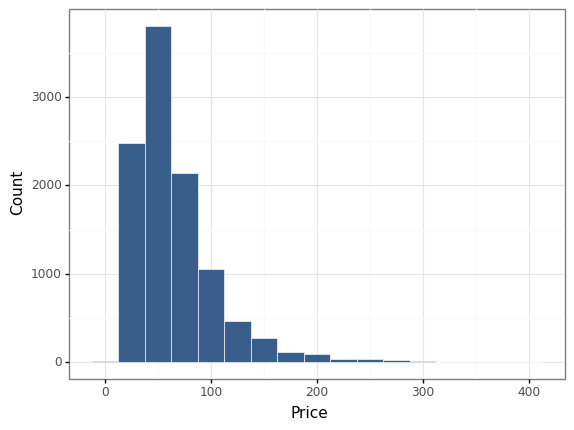

<ggplot: (8777236877493)>

In [34]:
# Histograms
(
    ggplot(data, aes('price'))
    + geom_histogram(
        binwidth=25, fill=color[0], color='white', alpha=0.8, size=0.25, closed='left'
    )
    + ylab('Count')
    + xlab('Price')
    + theme_bw()
)

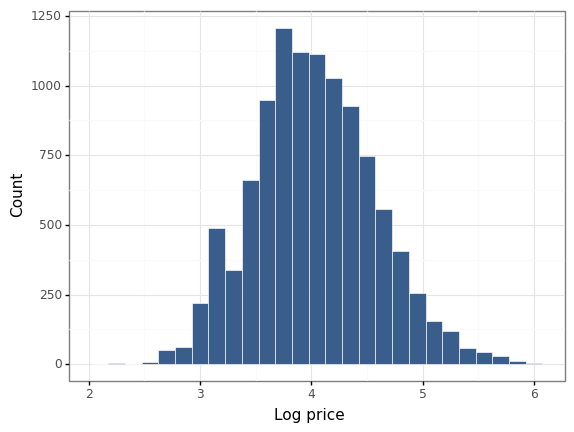

<ggplot: (8777206130520)>

In [35]:
(
    ggplot(data, aes('ln_price'))
    + geom_histogram(
        binwidth=0.15, fill=color[0], color='white', alpha=0.8, size=0.25, closed='left'
    )
    + ylab('Count')
    + xlab('Log price')
    + theme_bw()
)

**Find out the relation bewteen number of people accomodated and price in graph and table**

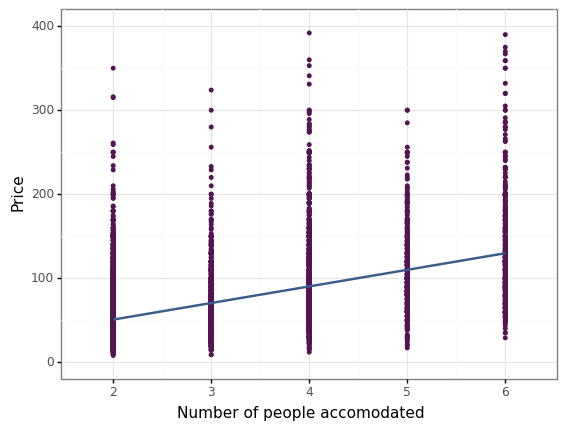

<ggplot: (8777219996407)>

In [36]:
(
    ggplot(data, aes(x='n_accommodates', y='price'))
    + geom_point(size=1, colour=color[2])
    + ylim(0, 400)
    + xlim(1.7, 6.3)
    + labs(x='Number of people accomodated', y='Price')
    + geom_smooth(method='lm', colour=color[0], se=False)
    + theme_bw()
)

In [37]:
data.groupby('n_accommodates').agg(mean_price=('price', np.mean))

,mean_price
n_accommodates,
2.0,51.712230
3.0,65.236636
4.0,89.119913
5.0,111.515075
6.0,135.908397


**Find out the relation bewteen bathroom and price in graph and table**

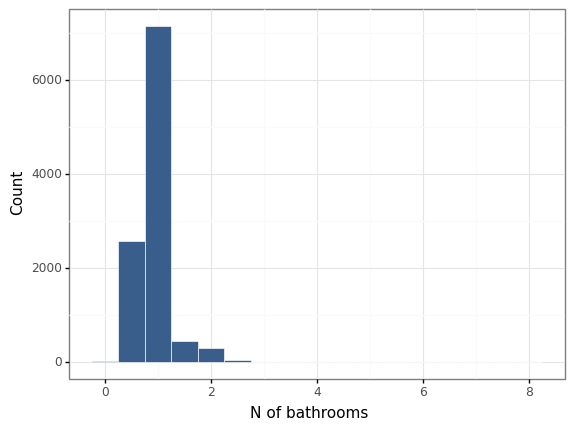

<ggplot: (8777237587577)>

In [38]:
## bathrooms
(
    ggplot(data, aes('n_bathrooms'))
    + geom_histogram(
        binwidth=0.5, closed='left', fill=color[0], color='white', alpha=0.8, size=0.25
    )
    + ylab('Count')
    + xlab('N of bathrooms')
    + theme_bw()
)

In [39]:
# Pool accomodations with 0,1,[2~10) bathrooms
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 10)], closed='left')
f_bath = pd.cut(data['n_bathrooms'].to_list(), bins, labels=['0', '1', '2'])
f_bath.categories = [0, 1, 2]
data['f_bathroom'] = f_bath

In [40]:
data.groupby('f_bathroom').agg(mean_price=('price', np.mean), n=('price', 'size'))

,mean_price,n
f_bathroom,,
0,39.615027,2795
1,71.936936,7421
2,132.310734,354


In [41]:
data.groupby('n_beds').agg(
    mean_price=('price', np.mean),
    min_price=('price', np.min),
    max_price=('price', np.max),
    n=('price', 'size'),
)

,mean_price,min_price,max_price,n
n_beds,,,,
0.0,64.596306,16.0,277.0,379
1.0,53.140251,10.0,350.0,6139
2.0,73.506385,8.0,360.0,2741
3.0,98.515228,16.0,359.0,788
4.0,115.537791,23.0,390.0,344
5.0,116.352381,21.0,305.0,105
6.0,127.984848,24.0,392.0,66
7.0,155.857143,69.0,266.0,7
8.0,85.000000,85.0,85.0,1


**Find out the relation bewteen bathroom and beds in graph and table**

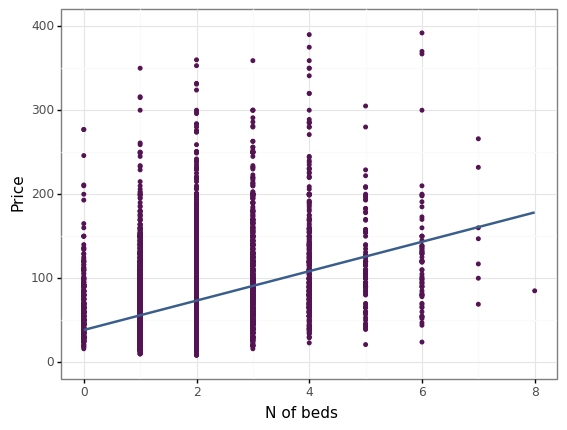

<ggplot: (8777236502212)>

In [42]:
(
    ggplot(data, aes(x='n_beds', y='price'))
    + geom_point(size=1, colour=color[2])
    + ylim(0, 400)
    + xlim(0, 8)
    + labs(x='N of beds', y='Price')
    + geom_smooth(method='lm', colour=color[0], se=False)
    + theme_bw()
)

**Find out the reviews bewteen bathroom and beds in graph and table**

In [43]:
## Number of reviews
nreview_plot = data.loc[data.n_number_of_reviews <200]

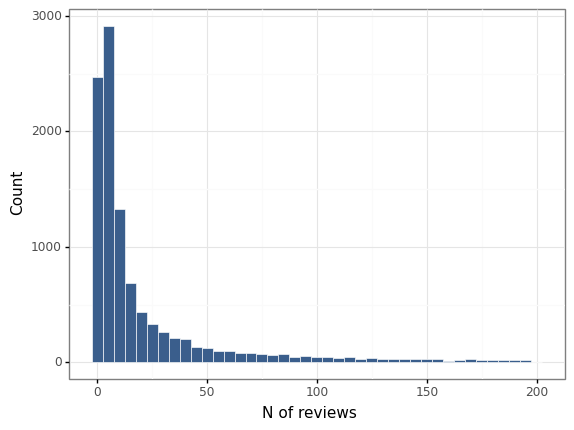

<ggplot: (8777206134685)>

In [44]:
(
    ggplot(nreview_plot, aes('n_number_of_reviews'))
    + geom_histogram(binwidth=5, fill=color[0], color='white', alpha=0.8, size=0.25)
    + ylab('Count')
    + xlab('N of reviews')
    + theme_bw()
)

In [45]:
bins = pd.IntervalIndex.from_tuples([(0, 2), (2, 51), (51, max(data.n_number_of_reviews))], closed='left')
f_number_of_reviews = pd.cut(data['n_number_of_reviews'].to_list(), bins, labels=['0', '1', '2'])
f_number_of_reviews.categories = [0, 1, 2]
data['f_number_of_reviews'] = f_number_of_reviews

In [46]:
data.groupby('f_number_of_reviews').agg(median_price=('price', np.median), mean_price=('price', np.mean), n=('price', 'size'))

,median_price,mean_price,n
f_number_of_reviews,,,
0,50.0,59.757487,1369
1,54.0,63.947526,7661
2,65.0,77.755036,1539


In [47]:
# number of reviews: use logs as well
data['ln_number_of_reviews']=np.log(data.n_number_of_reviews+1)

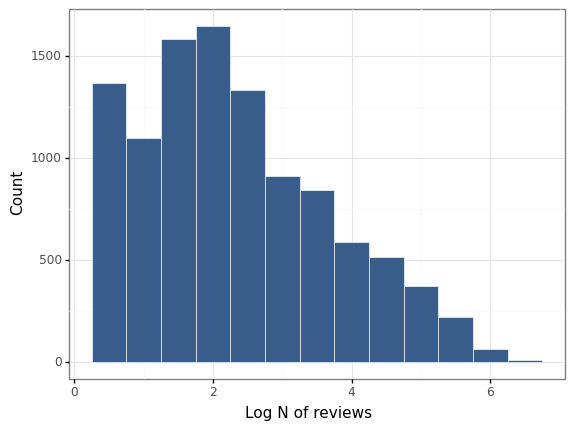

<ggplot: (8777218988126)>

In [48]:
(
    ggplot(data, aes('ln_number_of_reviews'))
    + geom_histogram(binwidth=0.5, fill=color[0], color="white", alpha=0.8, size=0.25)
    + ylab('Count')
    + xlab('Log N of reviews')
    + theme_bw()
)

In [49]:
data['ln_days_since'] = np.log(data['n_days_since'])

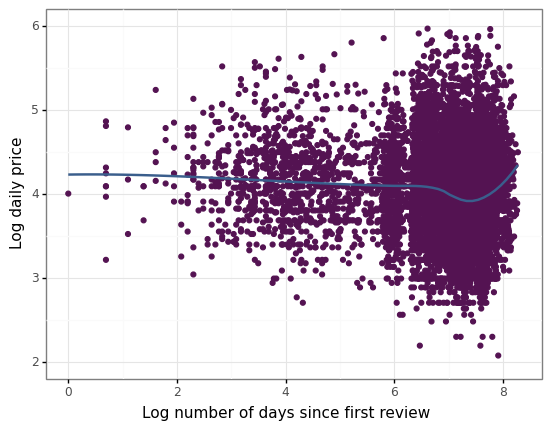

<ggplot: (8777237209781)>

In [50]:
(
    ggplot(data, aes(x='ln_days_since', y='ln_price'))
    + geom_point(size=1.5, colour=color[2])
    + ylim(2, 6)
    + xlim(0, 8.3)
    + geom_smooth(method='loess', colour=color[0], se=False)
    + labs(x='Log number of days since first review', y='Log daily price')
    + theme_bw()
)

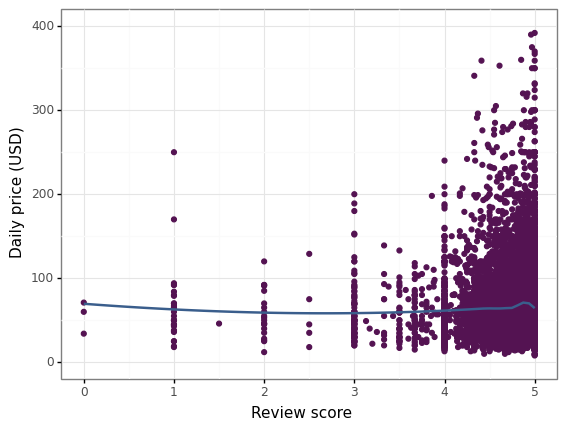

<ggplot: (8777218832918)>

In [51]:
## review score effect
(
    ggplot(data, aes(x='n_review_scores_rating', y='price'))
    + geom_point(size=1.5, colour=color[2])
    + ylim(0, 400)
    + xlim(0, 5)
    + geom_smooth(method="loess", colour=color[0], se=False)
    + labs(x='Review score', y='Daily price (USD)')
    + theme_bw()
)

## Data further analysis

**Price distribution in absolute and ln value**

In [52]:
# where do we have missing variables now?
na_filter=data.isna().sum()
na_filter[na_filter>0].index

Index(['f_number_of_reviews'], dtype='object')

In [53]:
data['f_number_of_reviews']=data['f_number_of_reviews'].fillna(1)

In [54]:
data.groupby('f_property_type').agg(mean_price=('price', np.mean))

,mean_price
f_property_type,
entire uint,80.656145
private room,40.812067


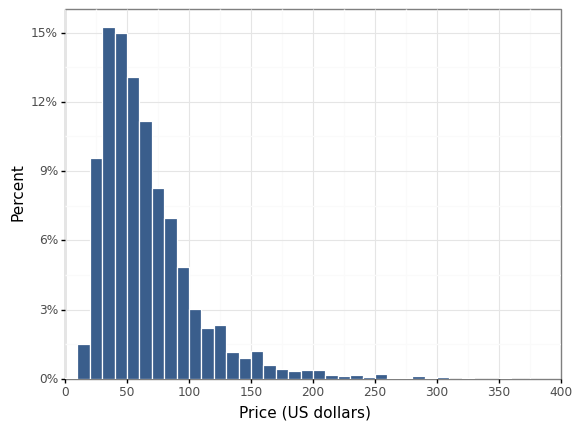

<ggplot: (8777237194972)>

In [55]:
# Distribution of price by type below 400# Histograms# price
(
    ggplot(data, aes(x='price'))
    + geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=10,
        fill=color[0],
        color='white',
        alpha=0.8,
        boundary=0,
        closed='left',
    )
    + labs(x='Price (US dollars)', y='Percent')
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.16),
        breaks=seq(0, 0.16, by=0.03),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.00), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
)

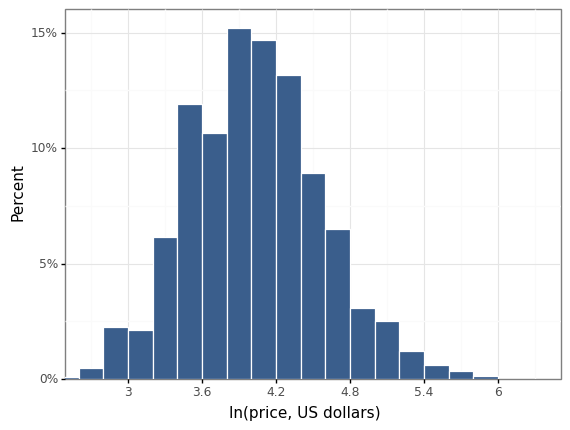

<ggplot: (8777237209676)>

In [56]:
(
    ggplot(data, aes(x='ln_price'))
    + geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.2,
        fill=color[0],
        color='white',
        alpha=0.8,
        boundary=0,
        closed='left',
    )
    + coord_cartesian(xlim=(2.5, 6.5))
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.16),
        breaks=seq(0, 0.16, by=0.05),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.01), breaks=seq(2.4, 6.7, 0.6))
    + labs(x='ln(price, US dollars)', y='Percent')
    + theme_bw()
)

**Analyse the room type with Box Plot, and accomodated people number are also included**

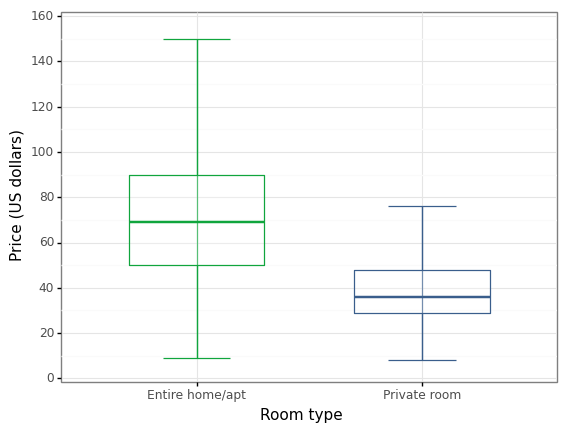

<ggplot: (8777218835622)>

In [57]:
## Boxplot of price by room type
(
    ggplot(data, aes(x='f_room_type', y='price'))
    + stat_boxplot(
        aes(group='f_room_type'),
        geom='errorbar',
        width=0.3,
        color=(color[1], color[0]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group='f_room_type'),
        color=(color[1], color[0]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape='',
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 160), breaks=seq(0, 201, 20))
    + labs(x='Room type', y='Price (US dollars)')
    + theme_bw()
)

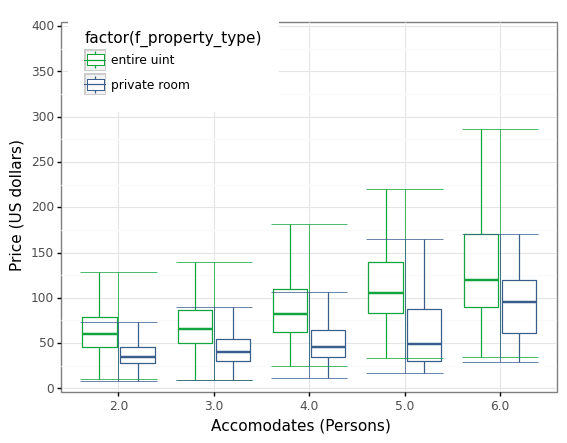

<ggplot: (8777210758295)>

In [58]:
(
    ggplot(
        data,
        aes(
            x='factor(n_accommodates)',
            y='price',
            color='factor(f_property_type)',
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape='', width=0.8, stat='boxplot')
    + stat_boxplot(geom='errorbar', width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name='', values=(color[1], color[0]))
    + scale_fill_manual(name='', values=(color[1], color[0]))
    + labs(x='Accomodates (Persons)', y='Price (US dollars)')
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

**Amenities should be also considered in predication,  elevator and TV are used combined with type of room or number of people accomodates for anaysis**

In [59]:
## Helper functions
def price_diff_by_variables2(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=('price', np.mean), sd=('price', np.std), size=('price', 'size')
    )
    stats['se'] = stats['sd'] / stats['size'] ** (1 / 2)
    stats['Mean_l'] = stats['Mean'] - (1.96 * stats['se'])
    stats['Mean_u'] = stats['Mean'] + (1.96 * stats['se'])
    stats = stats.drop(['sd', 'size'], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill='factor(' + stats.columns[1] + ')',
            ),
        )
        + geom_bar(stat='identity', position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin='Mean_l', ymax='Mean_u'),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab('Mean Price')
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position='top',
            legend_box='vertical',
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face='bold'),
        )
    )

    return plot

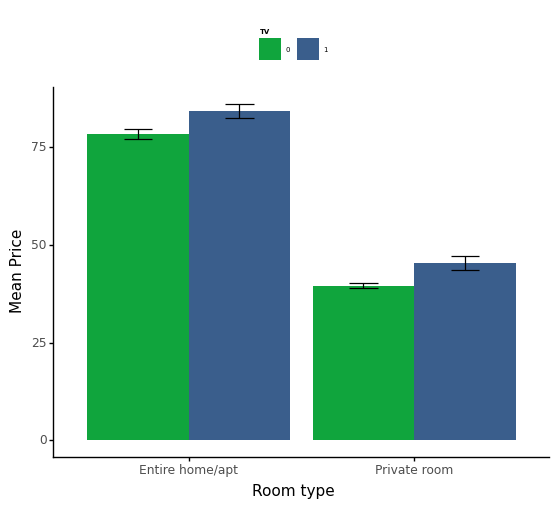

<ggplot: (8777237072288)>

In [60]:
price_diff_by_variables2(data,'f_room_type','d_TV','Room type', 'TV')

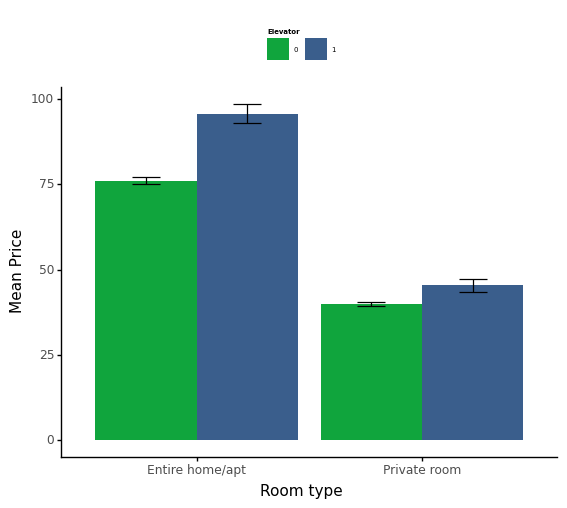

<ggplot: (8777219758361)>

In [61]:
price_diff_by_variables2(data,'f_room_type','d_Elevator','Room type', 'Elevator')

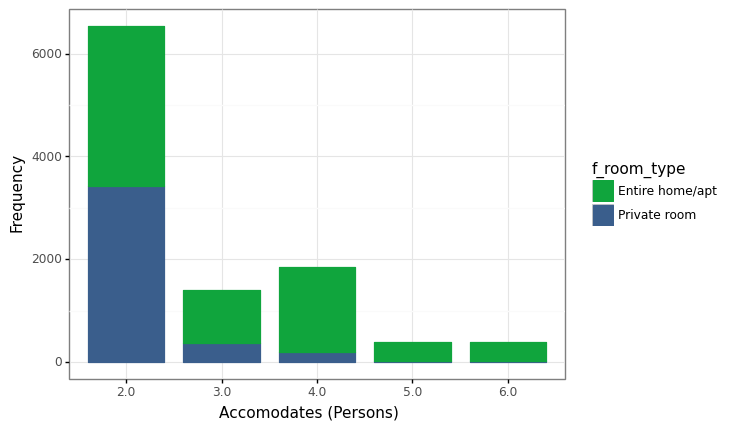

<ggplot: (8777219957390)>

In [62]:
# Barchart
(
    ggplot(
        data, aes(x='factor(n_accommodates)', color='f_room_type', fill='f_room_type')
    )
    + geom_bar(alpha=0.8, na_rm=True, width=0.8)
    + scale_color_manual(name='', values=(color[1], color[0], color[2]))
    + scale_fill_manual(name='', values=(color[1], color[0], color[2]))
    + labs(x='Accomodates (Persons)', y='Frequency')
    + theme_bw()
    + theme(legend_position='right')
)

## Model Prediction and Selection
### OLS, LASSO, CART and GBM are use for predication
### StandardScaler( ) is used for standardization

In [63]:
data.drop(columns=['neighbourhood_cleansed', 'room_type', 'property_type', 'f_property_type',
                  'f_room_type2', 'f_neighbourhood_cleansed', 'f_neighbourhood_group_cleansed',
                  'ln_price', 'id'], axis=1, inplace=True)

In [64]:
data['f_room_type'] = (data['f_room_type'] == 'Entire home/apt').astype(int)

In [65]:
X = data.drop(['price'], axis=1)  # X
y = data['price']  # target
# data standard
ss = StandardScaler()
X_std = ss.fit_transform(X)

88# train test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

### OLS model
#### Coefficients and their importance are draw for the easy comparison 

In [66]:
ols_model = LinearRegression().fit(X_train, y_train)
y_hat = ols_model.predict(X_test)
ols_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [67]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist(),
    index=X.columns,
    columns=['ols_coefficient'],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))
ols_model_coeffs_df.sort_values('ols_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'OLS Model Coeffs'}>

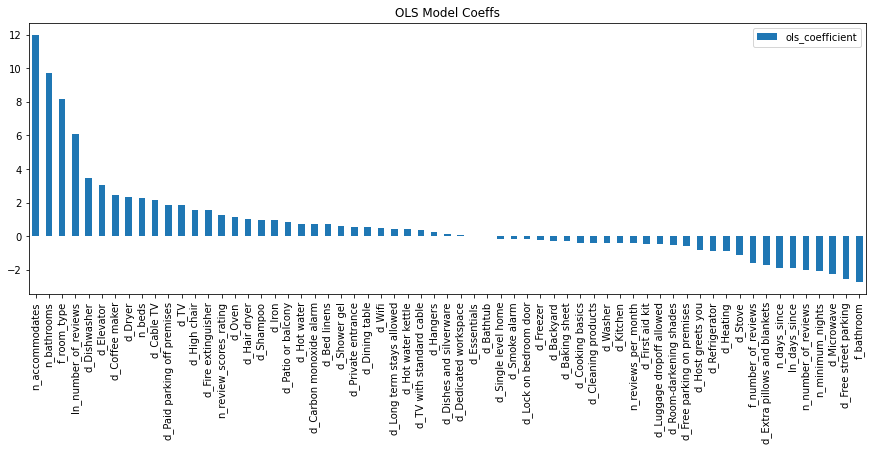

In [68]:
ols_model_coeffs_df.plot.bar(y='ols_coefficient', rot=90, figsize=(15, 5), title='OLS Model Coeffs')

In [69]:
ols_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(ols_model.coef_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

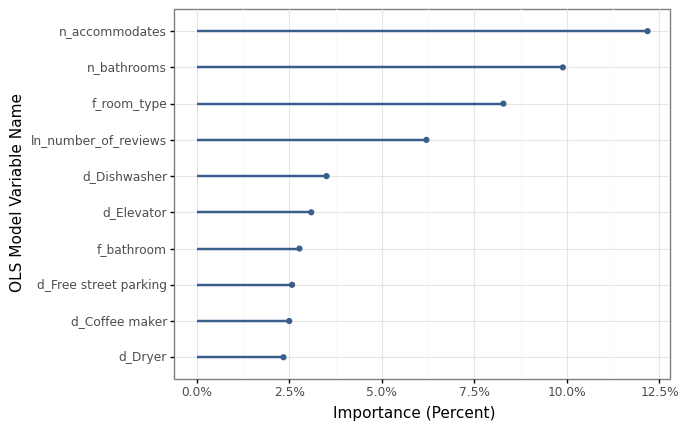

<ggplot: (8777220076791)>

In [70]:
ggplot(
    ols_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'OLS Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**Use cross validation and calulate RMSE for the futher RMSE comparison**

In [71]:
# cross validation
ols_model = LinearRegression()
ols_cv_mse = cross_val_score(ols_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_rmse = [np.sqrt(-x) for x in ols_cv_mse]

In [72]:
ols_cv_rmse

[29.28412078893475,
 32.53828249431209,
 29.392151995967893,
 31.241236658150154,
 31.157206101331965]

### LASSO model
#### Coefficients and their importance are draw for the easy comparison 

In [73]:
lasso_model = Lasso(alpha=0.5).fit(X_train, y_train)
y_hat = lasso_model.predict(X_test)
lasso_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [74]:
lasso_model_coeffs_df = pd.DataFrame(
    lasso_model.coef_.tolist(),
    index=X.columns,
    columns=['lasso_coefficient'],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3))
lasso_model_coeffs_df.sort_values('lasso_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'lasso Model Coeffs'}>

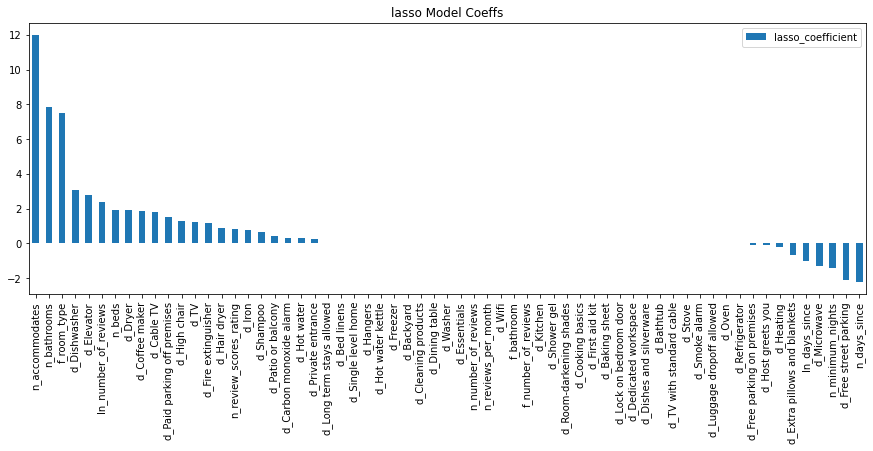

In [75]:
lasso_model_coeffs_df.plot.bar(y='lasso_coefficient', rot=90, figsize=(15, 5), title='lasso Model Coeffs')

In [76]:
lasso_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(lasso_model.coef_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

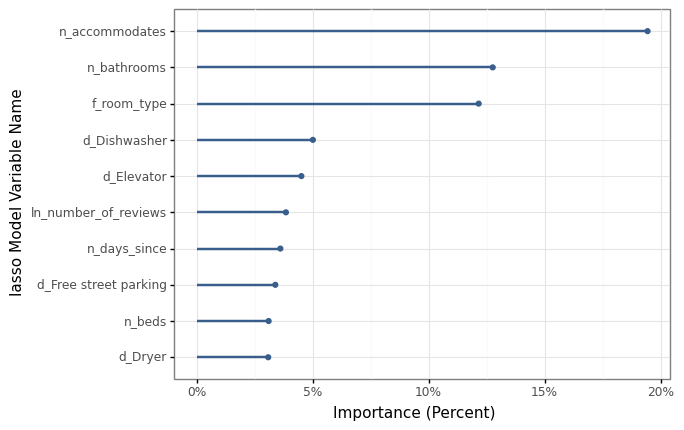

<ggplot: (8777206285668)>

In [77]:
ggplot(
    lasso_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'lasso Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**Use cross validation and calulate RMSE for the futher RMSE comparison**

In [78]:
# cross validation
lasso_model = Lasso(alpha=0.5)
lasso_cv_mse = cross_val_score(lasso_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
lasso_cv_rmse = [np.sqrt(-x) for x in lasso_cv_mse]

In [79]:
lasso_cv_rmse

[29.038324229640647,
 32.84099823915201,
 29.473791861809993,
 31.274808005783054,
 30.921404013044636]

### CART Model
#### Coefficients and their importance are draw for the easy comparison 

In [80]:
cart_model = DecisionTreeRegressor().fit(X_train, y_train)
y_hat = cart_model.predict(X_test)
cart_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [81]:
cart_model_coeffs_df = pd.DataFrame(
    cart_model.feature_importances_.tolist(),
    index=X.columns,
    columns=['cart_coefficient'],
).assign(cart_coefficient=lambda x: x.cart_coefficient.round(3))
cart_model_coeffs_df.sort_values('cart_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'cart Model Coeffs'}>

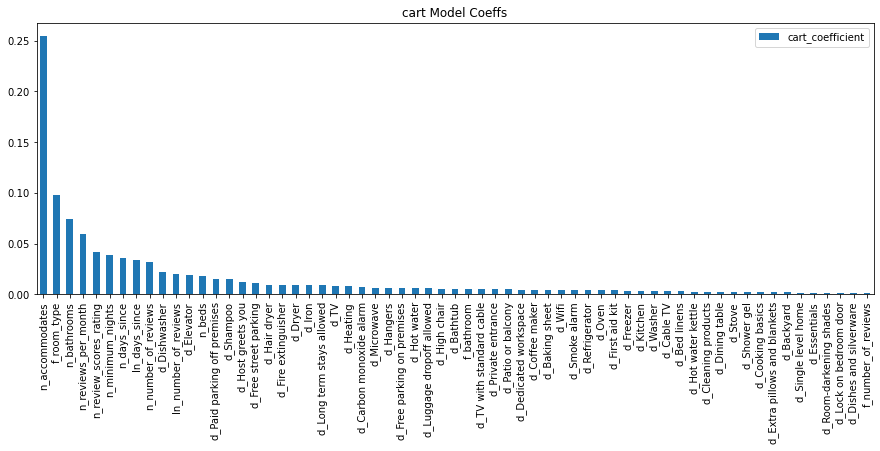

In [82]:
cart_model_coeffs_df.plot.bar(y='cart_coefficient', rot=90, figsize=(15, 5), title='cart Model Coeffs')

In [83]:
cart_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(cart_model.feature_importances_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

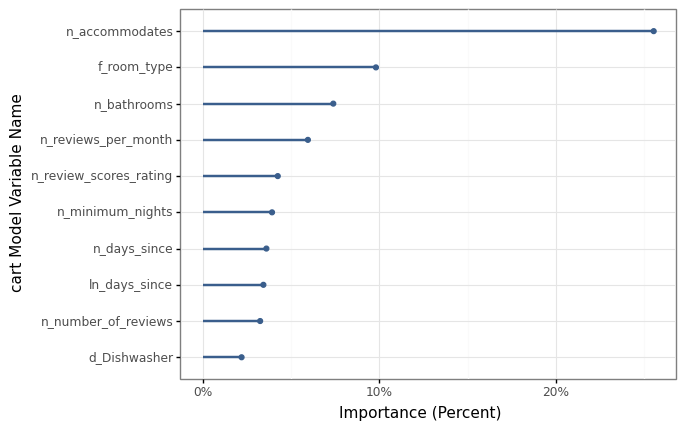

<ggplot: (8777237028645)>

In [84]:
ggplot(
    cart_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'cart Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**Use cross validation and calulate RMSE for the futher RMSE comparison**

In [85]:
# cross validation
cart_model = DecisionTreeRegressor()
cart_cv_mse = cross_val_score(cart_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
cart_cv_rmse = [np.sqrt(-x) for x in cart_cv_mse]

In [86]:
cart_cv_rmse

[49.53193879923311,
 41.365419357691195,
 40.6879929708534,
 42.60521507913616,
 47.47273280008263]

### GBM Model
#### Coefficients and their importance are draw for the easy comparison 

In [87]:
gbm_model = GradientBoostingRegressor().fit(X_train, y_train)
y_hat = gbm_model.predict(X_test)
gbm_rmse = mean_squared_error(y_test, y_hat, squared=False)

In [88]:
gbm_model_coeffs_df = pd.DataFrame(
    gbm_model.feature_importances_.tolist(),
    index=X.columns,
    columns=['gbm_coefficient'],
).assign(gbm_coefficient=lambda x: x.gbm_coefficient.round(3))
gbm_model_coeffs_df.sort_values('gbm_coefficient', inplace=True, ascending=False)

<AxesSubplot:title={'center':'gbm Model Coeffs'}>

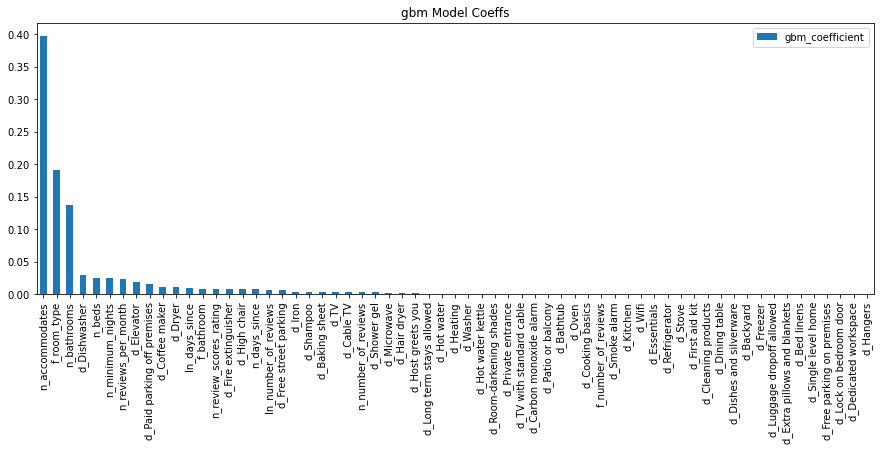

In [89]:
gbm_model_coeffs_df.plot.bar(y='gbm_coefficient', rot=90, figsize=(15, 5), title='gbm Model Coeffs')

In [90]:
gbm_model_coeffs_var_imp_df = (
    pd.DataFrame(
        abs(gbm_model.feature_importances_), X.columns
    )
    .reset_index()
    .rename({'index': 'varname',0: 'imp'}, axis=1)
    .assign(imp_percentage=lambda x: x['imp'] / x['imp'].sum())
    .sort_values(by=['imp'], ascending=False)
)

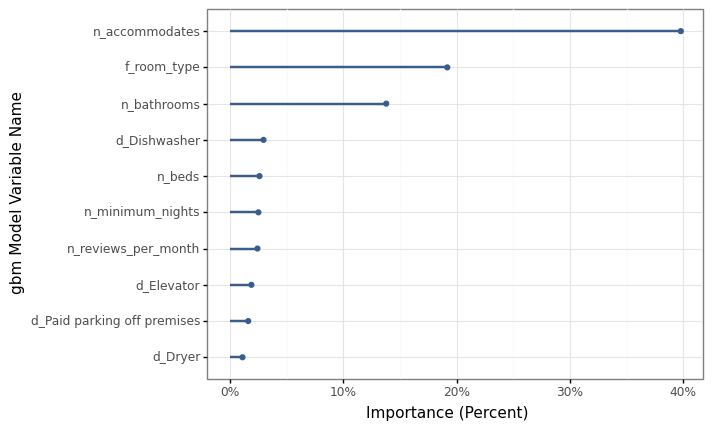

<ggplot: (8777206685847)>

In [91]:
ggplot(
    gbm_model_coeffs_var_imp_df.iloc[:10, :],
    aes(x='reorder(varname, imp)', y='imp_percentage'),
) + geom_point(color=color[0], size=1.5) + geom_segment(
    aes(x='varname', xend='varname', y=0, yend='imp_percentage'), color=color[0], size=1
) + ylab(
    'Importance (Percent)'
) + xlab(
    'gbm Model Variable Name'
) + coord_flip() + scale_y_continuous(
    labels=percent_format()
) + theme_bw()

**Use cross validation and calulate RMSE for the futher RMSE comparison**

In [92]:
# cross validation
gbm_model = GradientBoostingRegressor()
gbm_cv_mse = cross_val_score(gbm_model, X_std, y, cv=5, scoring='neg_mean_squared_error')
gbm_cv_rmse = [np.sqrt(-x) for x in gbm_cv_mse]

In [93]:
gbm_cv_rmse

[28.49027037114537,
 31.12546589850167,
 28.587358614113622,
 30.246294006638664,
 30.272738955859083]

In [94]:
def combine(type_, rmse):
    res = []
    index = 1
    for r in rmse:
        res.append([index, type_, r])
        index += 1
    return res

## Visual model prediction results 
### Results of RMSE for different test times with four models
### Average of RMSE for different test times with four models

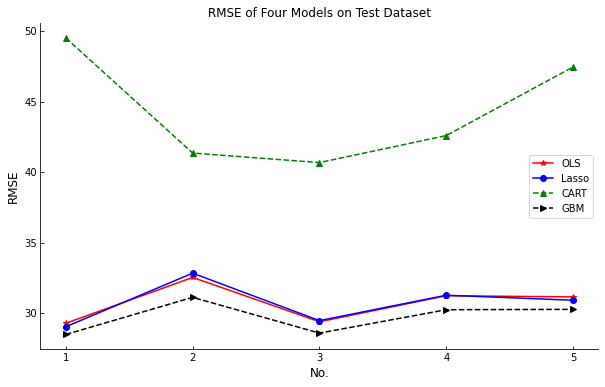

In [95]:
# cv RMSE compare
plt.figure(figsize=(10, 6))
plt.xlabel('No.', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
serial = [1, 2, 3, 4, 5]
plt.plot(serial, ols_cv_rmse, 'r-*', label='OLS')
plt.plot(serial, lasso_cv_rmse, 'b-o', label='Lasso')
plt.plot(serial, cart_cv_rmse, 'g--^', label='CART')
plt.plot(serial, gbm_cv_rmse, 'k-->', label='GBM')
plt.title('RMSE of Four Models on Test Dataset')
plt.xticks(serial)
plt.legend()
plt.show()

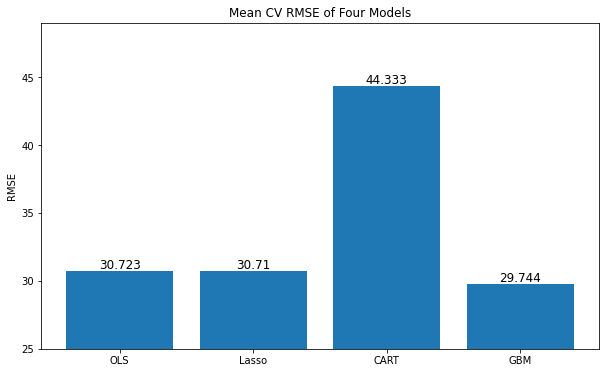

In [96]:
plt.figure(figsize=(10, 6))
x_list = ['OLS', 'Lasso', 'CART', 'GBM']
y_list = [round(np.mean(ols_cv_rmse), 3), 
          round(np.mean(lasso_cv_rmse), 3), 
          round(np.mean(cart_cv_rmse), 3), 
          round(np.mean(gbm_cv_rmse), 3)]
plt.bar(x_list, y_list)
plt.title('Mean CV RMSE of Four Models')
plt.ylabel('RMSE')
plt.ylim([25, 49])
for a, b in zip(x_list, y_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=12)
plt.show()

        With the help of the two graphs, we can easily judge GBM and lowest RMSE, which has the best predication result and is the best model. OLS and LASSO results are alomost the same, which seem not so bad. CART is the worst reuslt and has much higher RMSE than the other three.